<a href="https://colab.research.google.com/github/maimonahST/GP/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pip

In [2]:
! pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 30.7 MB/s eta 0:00:00


# Visualize Sample Data



In [ ]:
# prompt: import sample bdf file then viualise the raw data

import mne
import matplotlib.pyplot as plt

raw = mne.io.read_raw_bdf('/content/drive/MyDrive/GP/GP-Data/Haemorrhage/P10_TD1.bdf', preload=True)


Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P10_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11730943  =      0.000 ...   716.000 secs...


In [ ]:
print('Shape of the sample data', raw.get_data().shape)

Shape of the sample data (33, 11730944)


In [ ]:
print('info of the sample data', raw.info)

info of the sample data <Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 32 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 3334.0 Hz
 meas_date: 2016-06-02 16:20:57 UTC
 nchan: 33
 projs: []
 sfreq: 16384.0 Hz
 subject_info: 1 item (dict)
>


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 0.125 (s)


<ipython-input-65-929fdf3806e1>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=2000)


Current Sampling Frequency: 16384.0 Hz


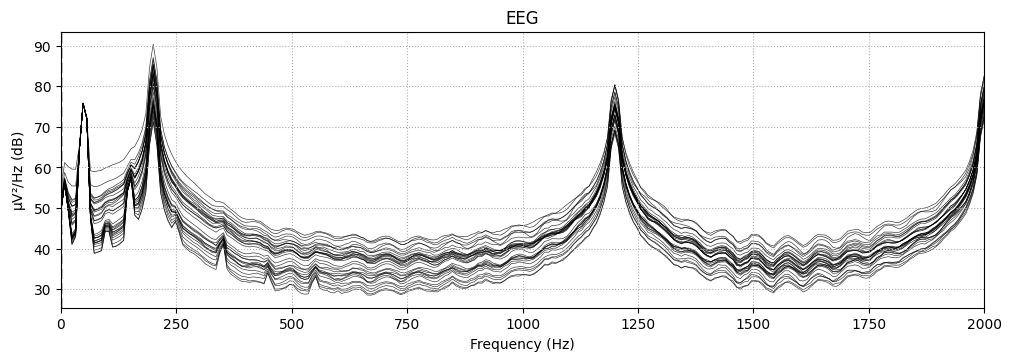

In [ ]:
# original data
raw.plot_psd(fmax=2000)

# Get the sampling frequency from the raw data
current_sfreq = raw.info['sfreq']
print(f"Current Sampling Frequency: {current_sfreq} Hz")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Sampling frequency of the instance is already 250.0, returning unmodified.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 124.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 124.50 Hz)
- Filter length: 1651 samples (6.604 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
<ipython-input-72-d572745e5f7b>:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=125)


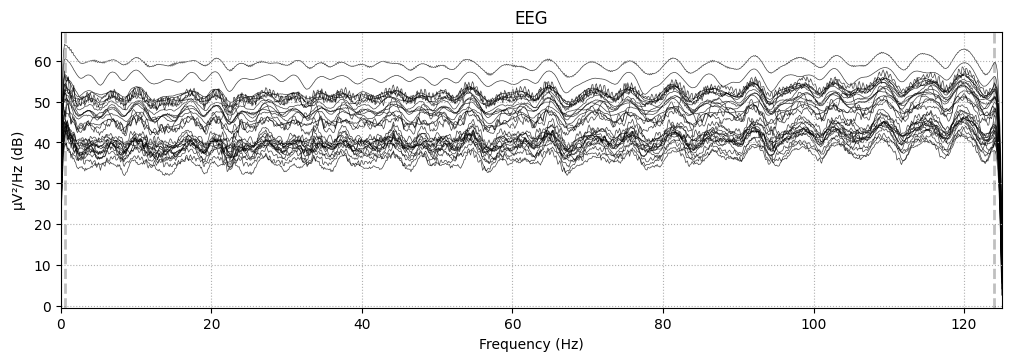

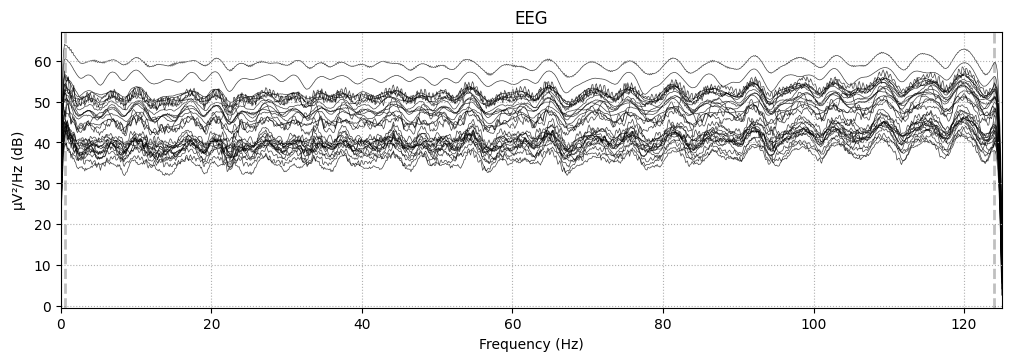

In [ ]:
  # Process the data
  raw.set_eeg_reference()
  raw.resample(250)
  raw.filter(0.5, 124, fir_design='firwin')


  # plot after processing the data
  raw.plot_psd(fmax=125)


# Load and Preprocess Data

In [3]:
from glob import glob
import mne
import numpy as np
from scipy import stats
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

def read_data(file_path):
    data = mne.io.read_raw_bdf(file_path, preload=True)
    data.set_eeg_reference()
    # Downsampling
    data.resample(250)
    data.filter(0.5, 25, fir_design='firwin')
    # Segmentation
    epochs = mne.make_fixed_length_epochs(data, duration=5, overlap=0.1)
    array = epochs.get_data()

    # Reshape the data for scaling
    num_samples, num_channels, num_time_points = array.shape
    array_reshaped = array.reshape(num_samples, -1)

    # Apply StandardScaler to the reshaped data
    scaler = StandardScaler()
    array_scaled = scaler.fit_transform(array_reshaped).reshape(array.shape)

    return array

def process_data(filepaths, label):
    epochs_array = []
    epochs_label = []

    for file_path in tqdm(filepaths, desc=f"Processing {label} data"):
        array = read_data(file_path)
        epochs_array.append(array)
        epochs_label.extend([label] * len(array))

    return epochs_array, epochs_label

# Filepaths
haemorrhage_filepaths = glob('/content/drive/MyDrive/GP/GP-Data/Haemorrhage/*.bdf')
ischaemia_filepaths = glob('/content/drive/MyDrive/GP/GP-Data/Ischaemia/*.bdf')
subject_filepaths = glob('/content/drive/MyDrive/GP/GP-Data/Subjects/*.bdf')

# Process data in chunks
chunk_size = 10  # Adjust the chunk size based on your memory constraints

haemorrhage_epochs_array = []
haemorrhage_epochs_label = []
for i in range(0, len(haemorrhage_filepaths), chunk_size):
    chunk_filepaths = haemorrhage_filepaths[i:i + chunk_size]
    chunk_array, chunk_label = process_data(chunk_filepaths, label=0)
    haemorrhage_epochs_array.extend(chunk_array)
    haemorrhage_epochs_label.extend(chunk_label)

ischaemia_epochs_array = []
ischaemia_epochs_label = []
for i in range(0, len(ischaemia_filepaths), chunk_size):
    chunk_filepaths = ischaemia_filepaths[i:i + chunk_size]
    chunk_array, chunk_label = process_data(chunk_filepaths, label=1)
    ischaemia_epochs_array.extend(chunk_array)
    ischaemia_epochs_label.extend(chunk_label)

subject_epochs_array = []
subject_epochs_label = []
for i in range(0, len(subject_filepaths), chunk_size):
    chunk_filepaths = subject_filepaths[i:i + chunk_size]
    chunk_array, chunk_label = process_data(chunk_filepaths, label=2)
    subject_epochs_array.extend(chunk_array)
    subject_epochs_label.extend(chunk_label)

# Concatenate results
data_array = np.vstack(haemorrhage_epochs_array + ischaemia_epochs_array + subject_epochs_array)
label_array = np.hstack(haemorrhage_epochs_label + ischaemia_epochs_label + subject_epochs_label)



Processing 0 data:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P2_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12238847  =      0.000 ...   747.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22491 events found on stim channel Status
Event IDs: [65284 65288 65296 65297 65301 65304 65305 65309 65311 65312 65313 65328
 65329 65336]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2889 events found on stim channel Status
Event IDs: [65296 65297 65305 65312 65313 65328 65329]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phas

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  10%|█         | 1/10 [00:47<07:06, 47.39s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P3_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11649023  =      0.000 ...   711.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22496 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2826 events found on stim channel Status
Event IDs: [65281 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  20%|██        | 2/10 [01:33<06:14, 46.81s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P5_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12058623  =      0.000 ...   736.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22486 events found on stim channel Status
Event IDs: [65281 65284 65294 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2902 events found on stim channel Status
Event IDs: [65281 65296 65297 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed t

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  30%|███       | 3/10 [02:20<05:26, 46.70s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P7a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11665407  =      0.000 ...   712.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22491 events found on stim channel Status
Event IDs: [65281 65284 65288 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2843 events found on stim channel Status
Event IDs: [65281 65296 65297 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  40%|████      | 4/10 [03:05<04:36, 46.05s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P7b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 13238271  =      0.000 ...   808.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22473 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2831 events found on stim channel Status
Event IDs: [65281 65282 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  50%|█████     | 5/10 [03:51<03:49, 45.96s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P10_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11730943  =      0.000 ...   716.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22474 events found on stim channel Status
Event IDs: [65281 65284 65286 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2752 events found on stim channel Status
Event IDs: [65281 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  60%|██████    | 6/10 [04:40<03:08, 47.24s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P11_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11632639  =      0.000 ...   710.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22482 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2845 events found on stim channel Status
Event IDs: [65281 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  70%|███████   | 7/10 [05:25<02:18, 46.33s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P14_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11649023  =      0.000 ...   711.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22483 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311 65312 65313 65328
 65329]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2787 events found on stim channel Status
Event IDs: [65281 65296 65297 65312 65313 65328 65329]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, no

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  80%|████████  | 8/10 [06:15<01:35, 47.63s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P6b_TD2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11698175  =      0.000 ...   714.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22484 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2903 events found on stim channel Status
Event IDs: [65281 65296 65297 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  90%|█████████ | 9/10 [07:07<00:48, 48.83s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P17_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12189695  =      0.000 ...   744.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22483 events found on stim channel Status
Event IDs: [65281 65282 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2799 events found on stim channel Status
Event IDs: [65281 65296 65297 65301]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:   0%|          | 0/5 [00:00<?, ?it/s]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P20_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11616255  =      0.000 ...   709.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22481 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2862 events found on stim channel Status
Event IDs: [65281 65296 65297 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  20%|██        | 1/5 [00:50<03:21, 50.43s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P21_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12812287  =      0.000 ...   782.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22485 events found on stim channel Status
Event IDs: [65281 65284 65293 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2802 events found on stim channel Status
Event IDs: [65281 65296 65297 65305]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  40%|████      | 2/5 [01:43<02:36, 52.08s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P23a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11681791  =      0.000 ...   713.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22490 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2821 events found on stim channel Status
Event IDs: [65281 65296 65297 65304 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  60%|██████    | 3/5 [02:30<01:39, 49.54s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P24_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11812863  =      0.000 ...   721.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22475 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2886 events found on stim channel Status
Event IDs: [65281 65296 65297 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 0 data:  80%|████████  | 4/5 [03:17<00:48, 48.65s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Haemorrhage/P23b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 17498111  =      0.000 ...  1068.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22476 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2920 events found on stim channel Status
Event IDs: [65281 65296 65297 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped


Processing 1 data:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P1_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11599871  =      0.000 ...   708.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22488 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2825 events found on stim channel Status
Event IDs: [65281 65296 65297 65304 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  10%|█         | 1/10 [00:47<07:04, 47.14s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P4a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11698175  =      0.000 ...   714.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22490 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2823 events found on stim channel Status
Event IDs: [65281 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  20%|██        | 2/10 [01:31<06:02, 45.37s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P4b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11665407  =      0.000 ...   712.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22478 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2866 events found on stim channel Status
Event IDs: [65281 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain de

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  30%|███       | 3/10 [02:15<05:14, 44.98s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P9_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 13107199  =      0.000 ...   800.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22477 events found on stim channel Status
Event IDs: [ 65281  65284  65296  65297  65301  65304  65305  65309  65311 130816]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2867 events found on stim channel Status
Event IDs: [ 65281  65296  65297  65311 130816]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  40%|████      | 4/10 [03:01<04:30, 45.13s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P12a_TD2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11730943  =      0.000 ...   716.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22485 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2821 events found on stim channel Status
Event IDs: [65281 65282 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-do

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  50%|█████     | 5/10 [03:45<03:45, 45.01s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P12b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11763711  =      0.000 ...   718.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22486 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2828 events found on stim channel Status
Event IDs: [65281 65296 65297 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-do

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  60%|██████    | 6/10 [04:34<03:04, 46.24s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P15_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11632639  =      0.000 ...   710.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22480 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2803 events found on stim channel Status
Event IDs: [65281 65296 65297 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-dom

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  70%|███████   | 7/10 [05:22<02:20, 46.71s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P16_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11698175  =      0.000 ...   714.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22482 events found on stim channel Status
Event IDs: [65281 65284 65285 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2884 events found on stim channel Status
Event IDs: [65281 65282 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed ti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  80%|████████  | 8/10 [06:13<01:36, 48.26s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P19a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11649023  =      0.000 ...   711.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22475 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2791 events found on stim channel Status
Event IDs: [65281 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  90%|█████████ | 9/10 [07:03<00:48, 48.67s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P18_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11681791  =      0.000 ...   713.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22481 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2918 events found on stim channel Status
Event IDs: [65281 65296 65297 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-dom

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:   0%|          | 0/4 [00:00<?, ?it/s]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P19b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11616255  =      0.000 ...   709.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22497 events found on stim channel Status
Event IDs: [65281 65284 65292 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2932 events found on stim channel Status
Event IDs: [65281 65296 65297 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed t

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  25%|██▌       | 1/4 [00:46<02:19, 46.34s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P25a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11747327  =      0.000 ...   717.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22479 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2848 events found on stim channel Status
Event IDs: [65281 65282 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-do

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  50%|█████     | 2/4 [01:33<01:34, 47.05s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P25b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11649023  =      0.000 ...   711.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22486 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2876 events found on stim channel Status
Event IDs: [65281 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain d

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 1 data:  75%|███████▌  | 3/4 [02:21<00:47, 47.40s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Ischaemia/P26_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12206079  =      0.000 ...   745.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22481 events found on stim channel Status
Event IDs: [65281 65282 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2864 events found on stim channel Status
Event IDs: [65281 65296 65297 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed ti

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:   0%|          | 0/10 [00:00<?, ?it/s]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S1a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12042239  =      0.000 ...   735.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22474 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2844 events found on stim channel Status
Event IDs: [65281 65296 65297 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-doma

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  10%|█         | 1/10 [00:47<07:11, 47.91s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S2a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11665407  =      0.000 ...   712.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22477 events found on stim channel Status
Event IDs: [65281 65282 65284 65295 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2895 events found on stim channel Status
Event IDs: [65281 65296 65297 65305]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Window

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  20%|██        | 2/10 [01:33<06:11, 46.48s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S1b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12746751  =      0.000 ...   778.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22479 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2867 events found on stim channel Status
Event IDs: [65281 65296 65297 65304 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  30%|███       | 3/10 [02:20<05:27, 46.73s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S3a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11665407  =      0.000 ...   712.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22485 events found on stim channel Status
Event IDs: [65281 65284 65292 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2802 events found on stim channel Status
Event IDs: [65281 65292 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  40%|████      | 4/10 [03:09<04:46, 47.72s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S3b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11632639  =      0.000 ...   710.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22489 events found on stim channel Status
Event IDs: [65281 65282 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2857 events found on stim channel Status
Event IDs: [65281 65296 65297 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  50%|█████     | 5/10 [04:00<04:03, 48.70s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S4a_TD2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11616255  =      0.000 ...   709.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22477 events found on stim channel Status
Event IDs: [65281 65282 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2800 events found on stim channel Status
Event IDs: [65281 65296 65297 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed tim

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  60%|██████    | 6/10 [04:48<03:14, 48.52s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S4b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11747327  =      0.000 ...   717.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22479 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2874 events found on stim channel Status
Event IDs: [65281 65296 65297 65301]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-doma

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  70%|███████   | 7/10 [05:38<02:27, 49.02s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S5a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11747327  =      0.000 ...   717.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22481 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2875 events found on stim channel Status
Event IDs: [65281 65296 65297 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-doma

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  80%|████████  | 8/10 [06:25<01:36, 48.47s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S5b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11665407  =      0.000 ...   712.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22485 events found on stim channel Status
Event IDs: [65281 65282 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2831 events found on stim channel Status
Event IDs: [65281 65296 65297 65301 65304]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Window

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  90%|█████████ | 9/10 [07:26<00:52, 52.30s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S6a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11714559  =      0.000 ...   715.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22477 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2870 events found on stim channel Status
Event IDs: [65281 65282 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-doma

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:   0%|          | 0/9 [00:00<?, ?it/s]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S6b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11649023  =      0.000 ...   711.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22484 events found on stim channel Status
Event IDs: [65281 65284 65289 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2807 events found on stim channel Status
Event IDs: [65281 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-doma

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  11%|█         | 1/9 [00:45<06:04, 45.62s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S7a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11616255  =      0.000 ...   709.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22473 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2868 events found on stim channel Status
Event IDs: [65281 65284 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-doma

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  22%|██▏       | 2/9 [01:33<05:30, 47.24s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S7b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11649023  =      0.000 ...   711.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22485 events found on stim channel Status
Event IDs: [65281 65284 65286 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2883 events found on stim channel Status
Event IDs: [65281 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-doma

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  33%|███▎      | 3/9 [02:19<04:39, 46.59s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S8a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11698175  =      0.000 ...   714.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22477 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2917 events found on stim channel Status
Event IDs: [65281 65282 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-doma

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  44%|████▍     | 4/9 [03:05<03:50, 46.04s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S8b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11960319  =      0.000 ...   730.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22482 events found on stim channel Status
Event IDs: [65281 65284 65294 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2854 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Window

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  56%|█████▌    | 5/9 [03:52<03:05, 46.39s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S9a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12419071  =      0.000 ...   758.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22485 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2867 events found on stim channel Status
Event IDs: [65281 65296 65297]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  67%|██████▋   | 6/9 [04:40<02:21, 47.01s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S10a_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11665407  =      0.000 ...   712.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22479 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2884 events found on stim channel Status
Event IDs: [65281 65296 65297 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-dom

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  78%|███████▊  | 7/9 [05:26<01:33, 46.89s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S9b_TD2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 12795903  =      0.000 ...   781.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22482 events found on stim channel Status
Event IDs: [65281 65284 65295 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2885 events found on stim channel Status
Event IDs: [65281 65288 65296 65297 65309]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Window

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data:  89%|████████▉ | 8/9 [06:18<00:48, 48.33s/it]

Extracting EDF parameters from /content/drive/MyDrive/GP/GP-Data/Subjects/S10b_TD1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 11599871  =      0.000 ...   708.000 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
22489 events found on stim channel Status
Event IDs: [65281 65284 65296 65297 65301 65304 65305 65309 65311]
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
2920 events found on stim channel Status
Event IDs: [65281 65296 65297 65311]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 25 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-dom

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
Processing 2 data: 100%|██████████| 9/9 [07:09<00:00, 47.73s/it]


In [4]:
# Combine epoch arrays for different classes into a single list
data_list= haemorrhage_epochs_array + ischaemia_epochs_array + subject_epochs_array
# Combine corresponding labels into a single list
label_list= haemorrhage_epochs_label + ischaemia_epochs_label + subject_epochs_label


# Print the lengths of the combined data and label lists for verification
print(len(data_list),len(label_list))


48 7150


In [5]:
# Create a list of groups, where each group corresponds to a class and has the same length as its respective data
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]

In [6]:
# Stack the data, labels, and groups into numpy arrays
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
group_array=np.hstack(groups_list)
# Move the axis to make the data suitable for input into a deep learning model (assuming a time series problem)
data_array=np.moveaxis(data_array,1,2)

# Print the shapes of the resulting arrays
print(data_array.shape,label_array.shape,group_array.shape)


(7150, 1250, 33) (7150,) (7150,)


# Save and Load Preprossed data

In [7]:

# save scaled data
np.save('/content/drive/MyDrive/GP/GP-Data/data_array.npy', data_array)
np.save('/content/drive/MyDrive/GP/GP-Data/label_array.npy', label_array)
np.save('/content/drive/MyDrive/GP/GP-Data/group_array.npy', group_array)



# save data without scaling
# np.save('/content/drive/MyDrive/GP/GP-Data/data_array_NS.npy', data_array)
# np.save('/content/drive/MyDrive/GP/GP-Data/label_array_NS.npy', label_array)
# np.save('/content/drive/MyDrive/GP/GP-Data/group_array_NS.npy', group_array)
